In [358]:
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import datetime
import seaborn as sns
from scipy import stats

In [352]:
symbols = ['TSLA','AMZN','GOOG','MSFT','MCD','AAPL']
names = ['Tesla','Amazon','Google','Microsoft','Mac','Apple']

market = 'SPY'

start = '2015-01-01'
end = '2020-01-01'

In [467]:
class Portfolio_allocator:
    
    pass

    def __init__(self):
        
        self.df = 0
    
    
    def datareader(self,list_of_symbols,list_of_names,start,end):
    
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)

        companies = []
        for i in range(len(list_of_symbols)):
            company = web.DataReader(list_of_symbols[i],'yahoo',start,end)
            company = company['Adj Close'].values.tolist()
            companies.append(company)

        df = pd.DataFrame(companies,index=list_of_names) 
        df = df.T
        
        self.df = df

        return df

    def plot_hist_of_log_return(self,df):

        log_return = np.log(df/df.shift(1))
        log_return.dropna(inplace=True)
        log_return.hist(bins = 100, figsize = (16,9))

        return plt.tight_layout()

    def calculate_mean_precentage_change(self,df,number_of_days):
        return df.pct_change(number_of_days).mean()

    def calculate_corr_precentage_change(self,df,number_of_days):
        return df.pct_change(number_of_days).corr()


    def yearly_covariance(self,lreturn):
        return log_return.cov()*252



    def effective_frontier(self,df):

        np.random.seed(101)

        log_return = np.log(df/df.shift(1))
        log_return.dropna(inplace=True)

        number_of_iterations = 5000
        weights = np.zeros((number_of_iterations,len(df.columns)))
        return_array = np.zeros(number_of_iterations)
        volatility_array = np.zeros(number_of_iterations)
        sharp_array = np.zeros(number_of_iterations)

        for num in range(number_of_iterations):

            #weights has to sum up to 1
            weight = np.array(np.random.random(len(df.columns)))
            weight = weight/np.sum(weight) 
            weights[num,:] = weight

            return_array[num] = np.sum((log_return.mean()*weight)*252)

            volatility_array[num] = np.sqrt(np.dot(weight.T,np.dot(log_return.cov()*252,weight)))

            sharp_array[num] = return_array[num]/ volatility_array[num]

        minimum_var = volatility_array.argmin()
        minimize_std_return = return_array[minimum_var]
        minimize_std_std = volatility_array[minimum_var]

        best_sharp = sharp_array.argmax()
        best_sharp_return = return_array[best_sharp]
        best_sharp_std = volatility_array[best_sharp]

        plt.figure(figsize=(16,9))
        plt.scatter(volatility_array,return_array, cmap = 'cividis')
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        plt.scatter(minimize_std_std,minimize_std_return,c='r')
        plt.text(minimize_std_std, minimize_std_return, 'Best portfolio allocation by minimizing std', ha = 'right');
        plt.scatter(best_sharp_std,best_sharp_return,c='r')
        plt.text(best_sharp_std, best_sharp_return, 'Best portfolio allocation by sharp ratio', ha = 'right');
        plt.title('The efficeincy frontier')

        return weights[best_sharp,:],weights[minimum_var,:]

    def plot_weights_of_optimal(self,minimum,sharp,list_of_names):

        fig, axes = plt.subplots(1, 2, figsize=(16,9))

        axes[0].pie(minimum, labels=list_of_names,autopct='%1.1f%%', shadow=True, startangle=140)
        axes[0].set_title('Weights : Minimum Variance Portfolio');

        axes[1].pie(sharp, labels=list_of_names,autopct='%1.1f%%', shadow=True, startangle=140)
        axes[1].set_title('Weights : Best sharp ratio');
        
        weights_df = pd.DataFrame({'Sharp':sharp, 'Minimum Variance':minimum})
        names_seris = pd.Series(names)
        weights_df.set_index(names_seris,inplace=True)
        index = weights_df.index
        index.name = "Weights"
        
        return weights_df
    
    def compare_annual_returns(self,df):
    
        daily_log_return = np.log(df/df.shift(1))
        daily_log_return.dropna(inplace=True)
        yearly_log_return = round((1+daily_log_return.mean())**252 -1,3)
        std_log_return = round((1+daily_log_return.std())**np.sqrt(252) -1,3)

        sharp_return = np.sum(yearly_log_return*sharp)
        minimum_return = np.sum(yearly_log_return*minimum)

        sharp_std = np.sum(std_log_return*sharp)
        minimum_std = np.sum(std_log_return*minimum)

        columns = ['Return','Std','Portfolio']
        data = {'Return': [sharp_return,minimum_return],'Std':[sharp_std,minimum_std],'Portfolio':['Sharp Portfolio','Minimum Variance Portfolio'] }
        data = pd.DataFrame(data,columns = columns)

        plt.figure(figsize=(16,9))
        sns.barplot(x='Portfolio', y='Return', data=data,label = 'Return',alpha = 0.4);
        sns.barplot(x='Portfolio', y='Std', data=data,color='lightblue',label = 'Std'); 
        plt.legend()
        plt.ylabel('Return')
        plt.xlabel('Method')
        plt.title('Comparing Annual Returns');


        return plt.show()

    def relation_portfolio_to_market(self,df,portfolio):

        #Using Spy as the market.
        #Choosing portfolio between sharp and minimum.

        spy = web.DataReader(market,'yahoo',start,end)
        spy['Daily_return'] = spy['Adj Close'].pct_change(1)
        spy.dropna(inplace=True)
        log_return = np.log(df/df.shift(1))
        log_return.dropna(inplace=True)
        plt.figure(figsize=(16,9))
        returns = np.sum(log_return*portfolio,axis=1)
        sns.regplot(sharp_returns,spy['Daily_return'],fit_reg=True)
        beta,alpha,r_squared,p_value,std = stats.linregress(returns,
                                                           spy['Daily_return'])

        dictionary = {'Beta':beta,'Alpha':alpha,'R-Squared':r_squared,'P_Value':p_value,'Standard deviation':std}


        linear_regression_param = dict() 
        for key in dictionary:  
             linear_regression_param[key] = round(dictionary[key], 3) 

        return print(linear_regression_param)

In [468]:
portfolio = Portfolio_allocator()

In [459]:
df = portfolio.datareader(symbols,names,start,end)

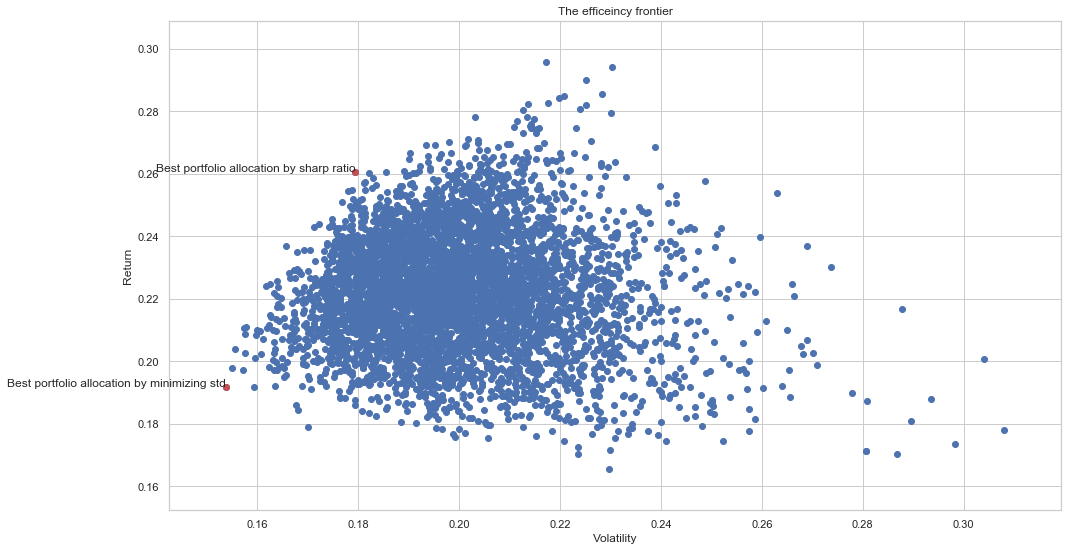

In [460]:
sharp , minimum = portfolio.effective_frontier(df)

,Sharp,Minimum Variance
Weights,,
Tesla,0.013091,0.058771
Amazon,0.369072,0.056725
Google,0.002013,0.175752
Microsoft,0.147310,0.045931
Mac,0.375561,0.653592
Apple,0.092952,0.009229


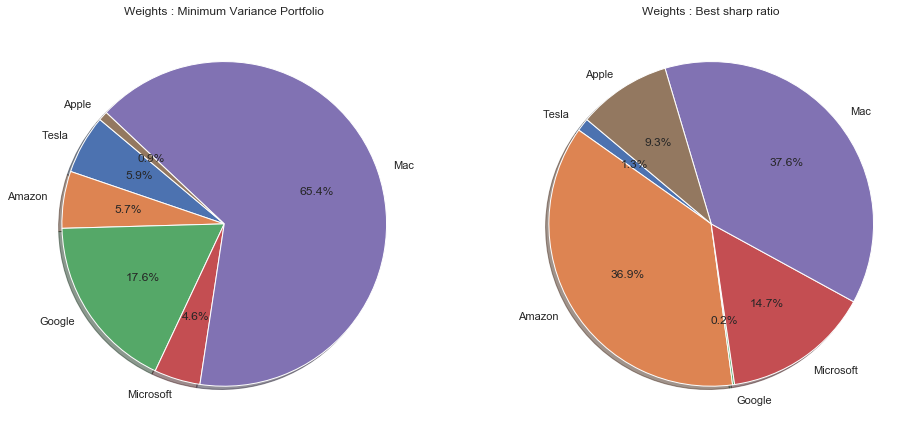

In [464]:
portfolio.plot_weights_of_optimal(minimum,sharp,names)

{'Beta': 0.583, 'Alpha': -0.0, 'R-Squared': 0.779, 'P_Value': 0.0, 'Standard deviation': 0.013}


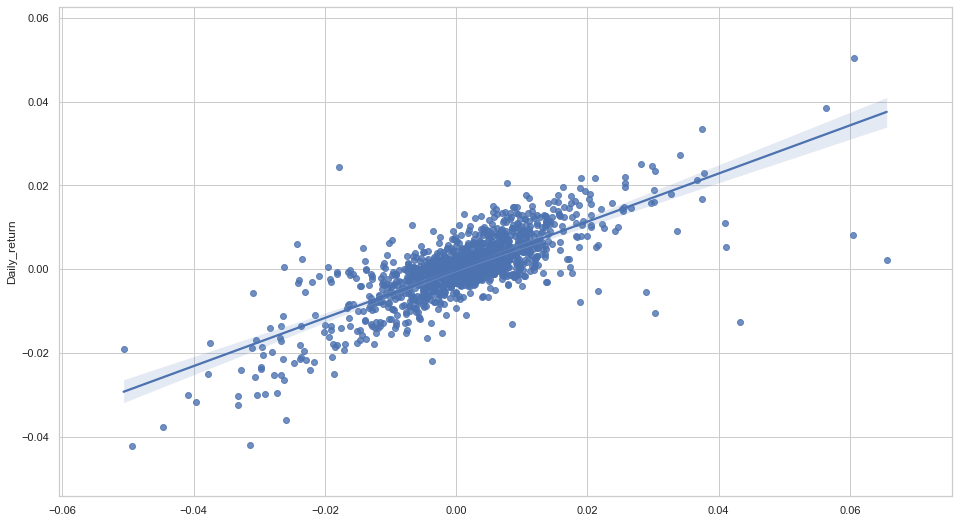

In [465]:
portfolio.relation_portfolio_to_market(df,sharp)

{'Beta': 0.626, 'Alpha': -0.0, 'R-Squared': 0.718, 'P_Value': 0.0, 'Standard deviation': 0.017}


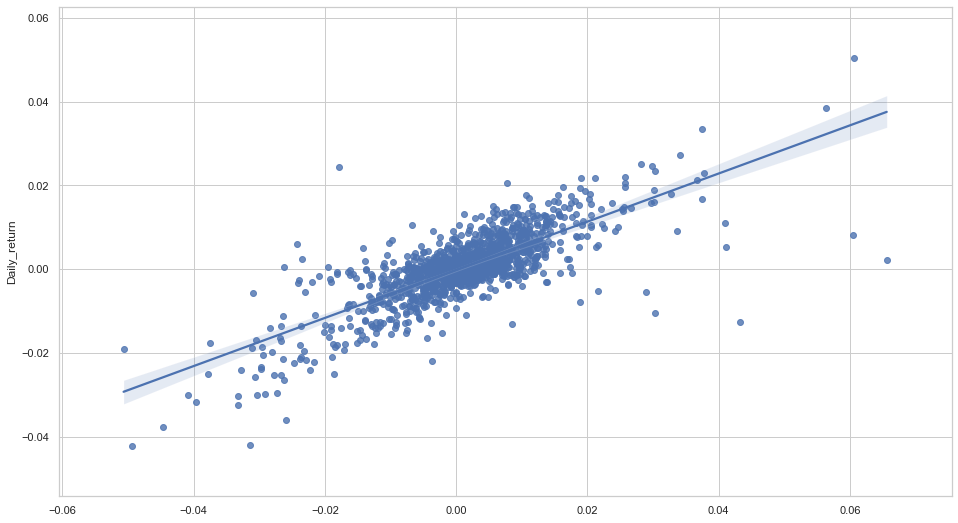

In [466]:
portfolio.relation_portfolio_to_market(df,minimum)

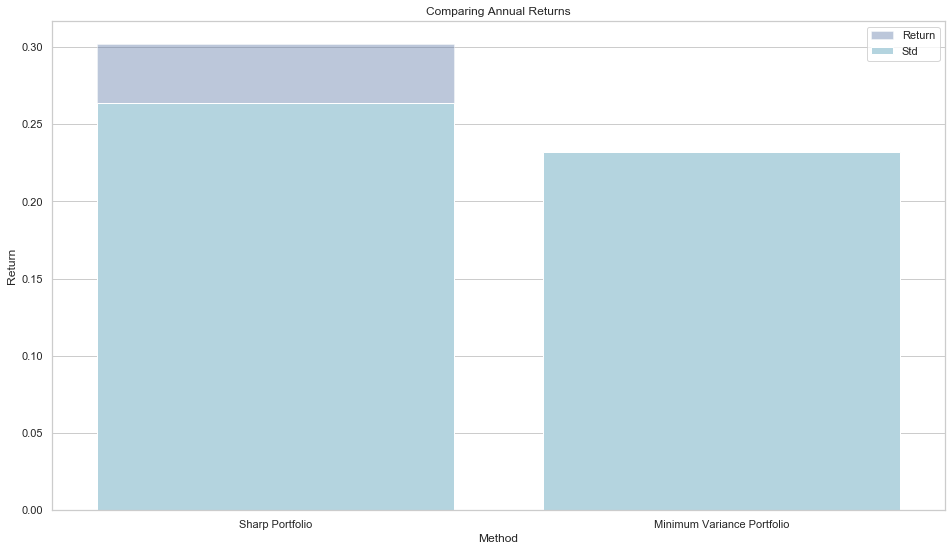

In [469]:
portfolio.compare_annual_returns(df)

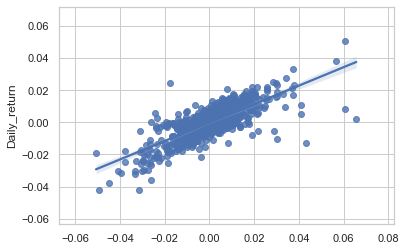

In [402]:
spy = web.DataReader(market,'yahoo',start,end)
spy['Daily_return'] = spy['Adj Close'].pct_change(1)
spy.dropna(inplace=True)
log_return = np.log(df/df.shift(1))
log_return.dropna(inplace=True)



{'Beta': 0.626, 'Alpha': -0.0, 'R-Squared': 0.718, 'P_Value': 0.0, 'Standard deviation': 0.017}


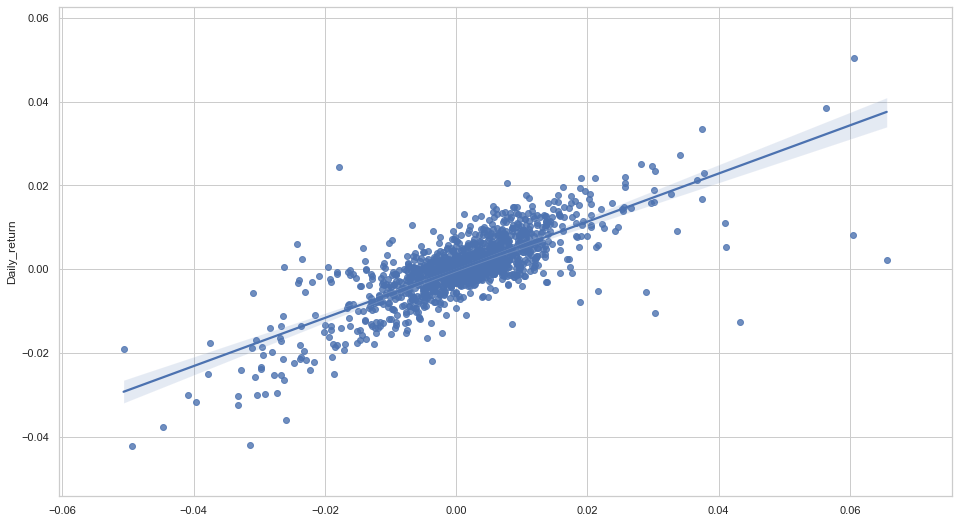

In [420]:
relation_portfolio_to_market(df,minimum)

,Tesla,Amazon,Google,Microsoft,Mac,Apple
0,43.862000,308.519989,523.373108,41.647892,79.688843,24.941502
1,42.018002,302.190002,512.463013,41.264908,78.808716,24.238857
2,42.256001,295.290009,500.585632,40.659245,78.954002,24.241146
3,42.189999,298.420013,499.727997,41.175831,80.329689,24.581060
4,42.124001,300.459991,501.303680,42.387146,80.628761,25.525522
...,...,...,...,...,...,...
1253,85.050003,1789.209961,1343.560059,156.137955,193.023178,70.580566
1254,86.188004,1868.770020,1360.400024,157.417786,193.405945,71.980911
1255,86.075996,1869.800049,1351.890015,157.705505,194.495361,71.953598
1256,82.940002,1846.890015,1336.140015,156.346298,193.258728,72.380653


0.7175068591840694

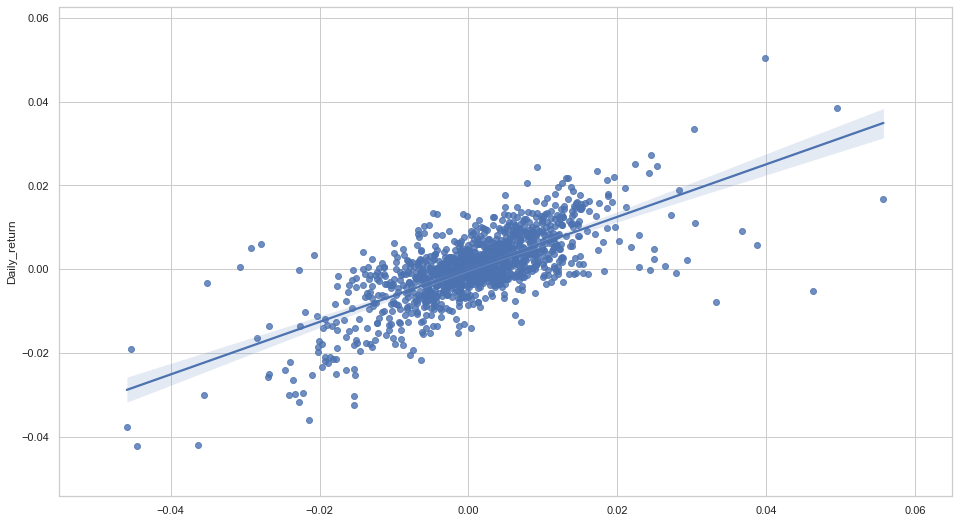

In [407]:
plt.figure(figsize=(16,9))
miniminum_var_returns = np.sum(log_return*minimum,axis=1)
sns.regplot(miniminum_var_returns,spy['Daily_return'],fit_reg=True)

beta,alpha,r_squared,p_value,std = stats.linregress(miniminum_var_returns,
                                                   spy['Daily_return'])

beta
r_squared

In [ ]:
plt.scatter(sharp_returns,spy['Daily_return'],alpha=0.3)

In [395]:
total = np.sum(log_return*sharp,axis=1)

In [398]:
log_return*sharp

,Tesla,Amazon,Google,Microsoft,Mac,Apple
1,-0.001331,-0.008008,-0.000700,-0.000605,-0.003996,-0.003551
2,0.000175,-0.008922,-0.000779,-0.000968,0.000663,0.000012
3,-0.000048,0.004073,-0.000057,0.000826,0.006215,0.001730
4,-0.000049,0.002632,0.000105,0.001897,0.001337,0.004685
5,-0.000588,-0.004565,-0.000433,-0.000552,-0.004412,0.000133
...,...,...,...,...,...,...
1253,0.000443,-0.000817,-0.000130,-0.000012,0.000861,0.000118
1254,0.000412,0.016806,0.000414,0.000534,0.000713,0.002441
1255,-0.000040,0.000213,-0.000208,0.000120,0.002021,-0.000047
1256,-0.001150,-0.004762,-0.000389,-0.000566,-0.002295,0.000735


-0.018191

In [396]:
total

1      -0.018190
2      -0.009820
3       0.012739
4       0.010607
5      -0.010418
          ...   
1253    0.000461
1254    0.021320
1255    0.002057
1256   -0.008428
1257    0.002718
Length: 1257, dtype: float64

In [393]:
spy['Daily_return']

Date
2015-01-05   -0.018060
2015-01-06   -0.009419
2015-01-07    0.012461
2015-01-08    0.017745
2015-01-09   -0.008014
                ...   
2019-12-24    0.000031
2019-12-26    0.005323
2019-12-27   -0.000248
2019-12-30   -0.005513
2019-12-31    0.002429
Name: Daily_return, Length: 1257, dtype: float64

In [389]:
len(sharp_returns)

6

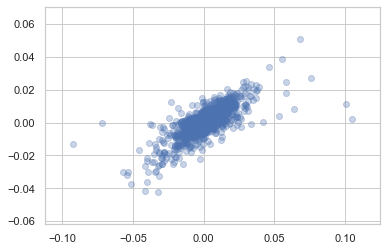

In [366]:
spy = web.DataReader(market,'yahoo',start,end)
msft = web.DataReader('MSFT','yahoo',start,end)
spy['Daily_return'] = spy['Close'].pct_change(1)
msft['Daily_return'] = msft['Close'].pct_change(1)
spy.dropna(inplace=True)
msft.dropna(inplace=True)
plt.scatter(msft['Daily_return'],spy['Daily_return'],alpha=0.3)
plt.show()


In [ ]:
def relation_bet_portfol_market(df):
    
    spy = web.DataReader(market,'yahoo',start,end)
    spy['Daily_return'] = spy['Adj Close'].pct_change(1)
    

In [367]:
msft['Daily_return']

Date
2015-01-05   -0.009196
2015-01-06   -0.014677
2015-01-07    0.012705
2015-01-08    0.029418
2015-01-09   -0.008405
                ...   
2019-12-24   -0.000191
2019-12-26    0.008197
2019-12-27    0.001828
2019-12-30   -0.008619
2019-12-31    0.000698
Name: Daily_return, Length: 1257, dtype: float64

In [368]:
spy['Daily_return']

Date
2015-01-05   -0.018060
2015-01-06   -0.009419
2015-01-07    0.012461
2015-01-08    0.017745
2015-01-09   -0.008014
                ...   
2019-12-24    0.000031
2019-12-26    0.005323
2019-12-27   -0.000248
2019-12-30   -0.005513
2019-12-31    0.002429
Name: Daily_return, Length: 1257, dtype: float64

In [369]:
beta,alpha,r_squared,p_value,std = stats.linregress(msft['Daily_return'],
                                                   spy['Daily_return'])

In [371]:
beta

0.4361893474372439

In [373]:
noise = np.random.normal(0,0.001,len(spy['Daily_return']))

In [375]:
fake_stock = spy['Daily_return'] + noise

In [382]:
beta,alpha,r_squared,p_value,std = stats.linregress(fake_stock,spy['Daily_return'])

In [383]:
beta

0.9881886392629046

In [356]:
spy_log_return = np.log(spy/spy.shift(1))
spy_log_return.dropna(inplace=True)
spy_log_return

Date
2015-01-05   -0.018225
2015-01-06   -0.009463
2015-01-07    0.012384
2015-01-08    0.017589
2015-01-09   -0.008046
                ...   
2019-12-24    0.000031
2019-12-26    0.005309
2019-12-27   -0.000248
2019-12-30   -0.005528
2019-12-31    0.002426
Name: Adj Close, Length: 1257, dtype: float64

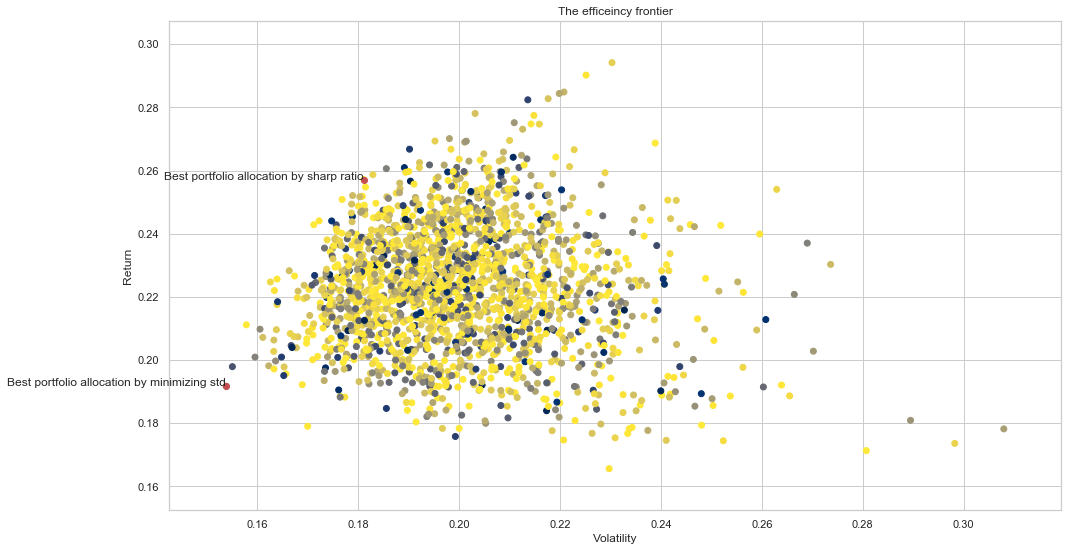

In [344]:
sharp, minimum = effective_frontier(df,log_return)

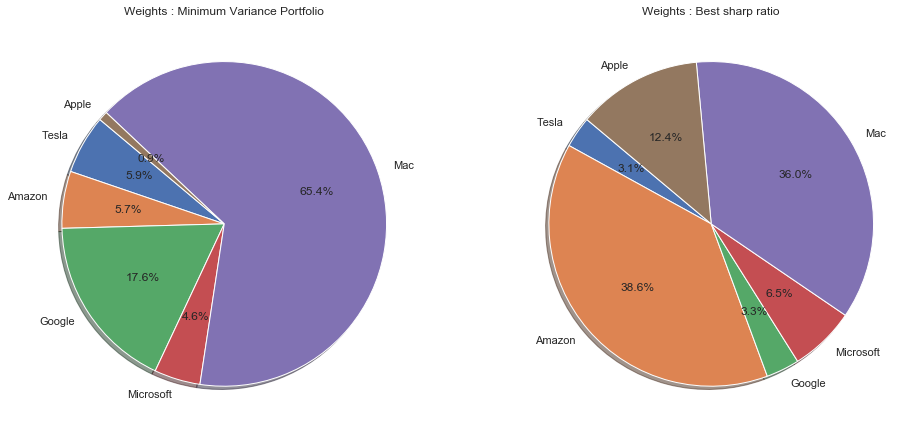

In [345]:
plot_weights_of_optimal(minimum,sharp,names)

In [248]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
בוקס פלוט
התיק האופטימלי שארפ 
התיק האופטימלי מינימום השונות 
תיק השוק

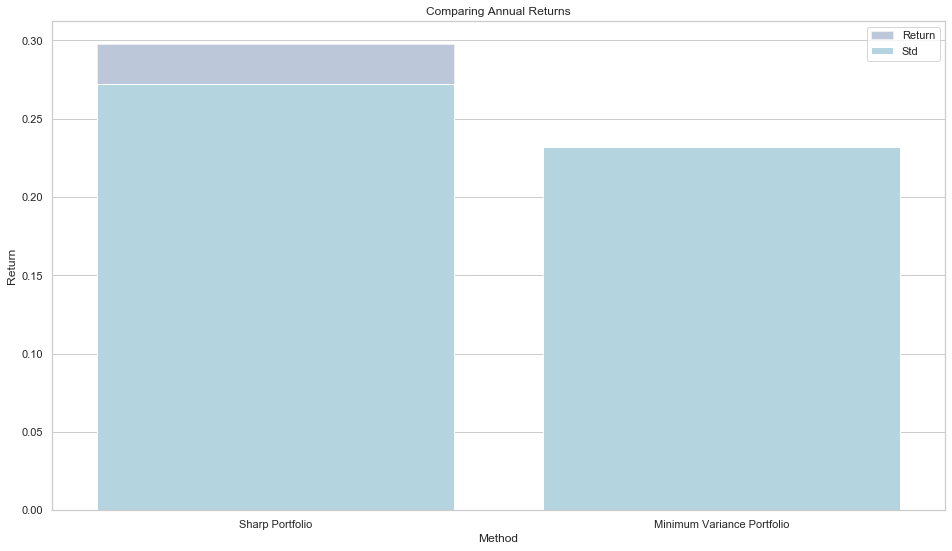

In [351]:
compare_annual_returns(df)

In [285]:
data = pd.DataFrame(data,columns = columns)

In [289]:
sharp_return.values

array([0.54405818, 0.05794277, 0.00159166])

In [278]:
sharp_portfolio

,Tadiran,Leumi,Ramilevi
1,0.000000,-0.000237,0.000000
2,0.003049,-0.001901,-0.000119
3,0.013848,0.003083,-0.000103
4,0.000000,-0.002131,0.000565
5,0.000000,-0.003584,0.000767
...,...,...,...
728,0.012132,0.002457,-0.000124
729,0.018889,-0.001687,0.000192
730,0.020865,0.004126,0.000115
731,0.001244,0.000455,0.000027


In [275]:
minimum_portfolio

Tadiran     0.183911
Leumi       0.091309
Ramilevi    0.034828
dtype: float64

In [272]:
minimum

array([0.2262127 , 0.50169575, 0.27209155])

In [260]:
data = pd.DataFrame(yearly_log_return,index = names,columns = ['annualized log return'])

In [261]:
data

,annualized log return
Tadiran,0.813
Leumi,0.182
Ramilevi,0.128


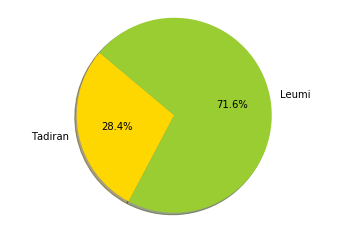

In [183]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,5))

labels = ['Tadiran', 'Leumi']
sizes = minimum
colors = ['gold', 'yellowgreen']

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

ValueError: 'label' must be of length 'x'

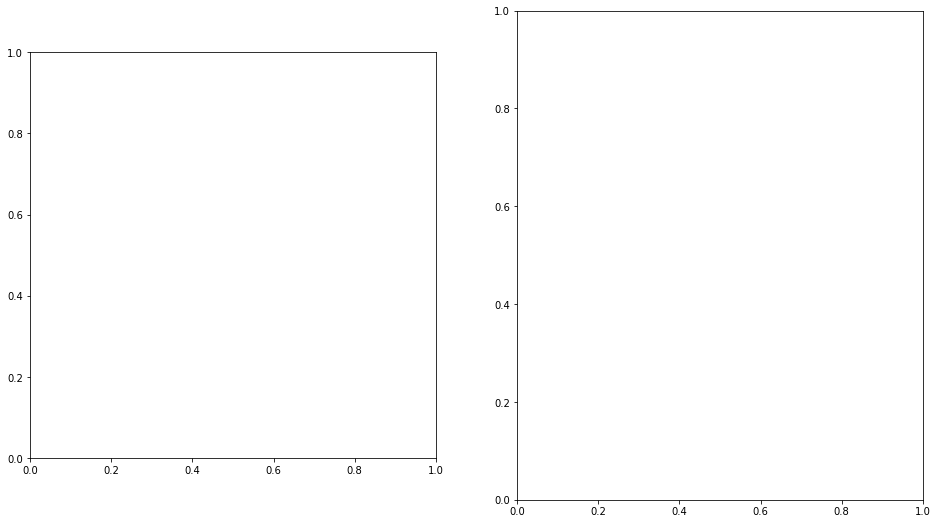

In [200]:
plot_weights_of_optimal(minimum,sharp,names)

In [225]:
log_return = np.log(df/df.shift(1))
log_return.dropna(inplace=True)

,Tadiran,Leumi,Ramilevi
1,0.000000,-0.000744,0.000000
2,0.004555,-0.005970,-0.009583
3,0.020694,0.009683,-0.008287
4,0.000000,-0.006694,0.045416
5,0.000000,-0.011257,0.061676
...,...,...,...
728,0.018130,0.007718,-0.009945
729,0.028226,-0.005300,0.015427
730,0.031179,0.012959,0.009252
731,0.001859,0.001429,0.002164


In [138]:
def plot_hist_of_log_return(df):
    
    log_return = np.log(df/df.shift(1))
    log_return.dropna(inplace=True)
    log_return.hist(bins = 100, figsize = (16,9))
    
    return plt.tight_layout()

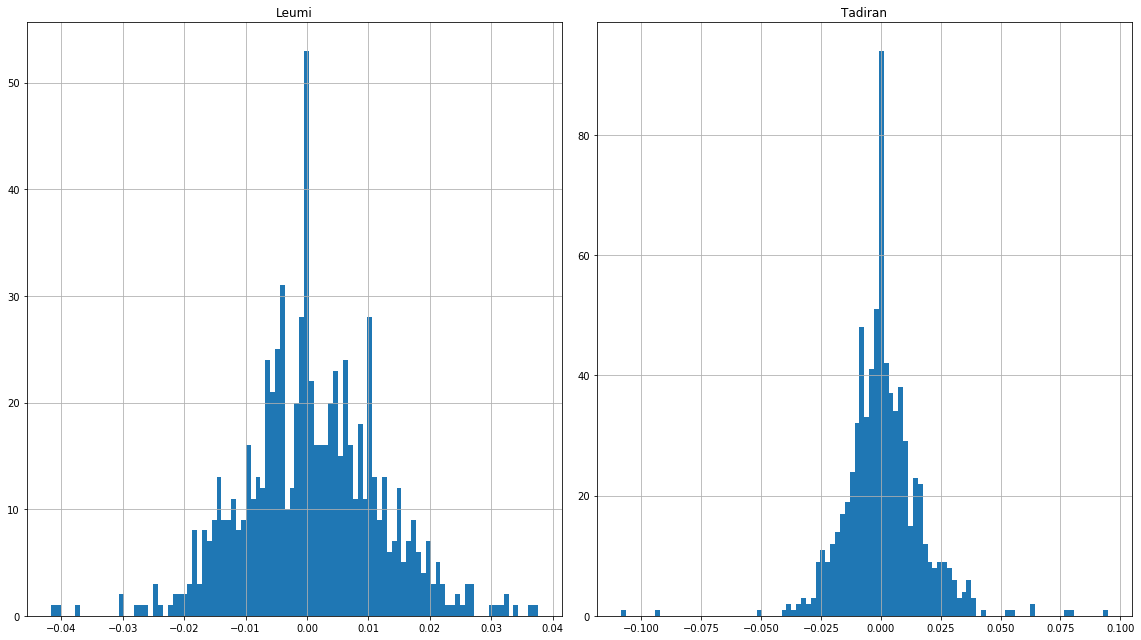

In [139]:
plot_hist_of_log_return(df)

In [9]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-01-01')

In [110]:
leumi['Adj Close'].values

array([ 999.05145264, 1012.49157715, 1033.09997559, ..., 1433.61657715,
       1421.07263184, 1419.28051758])

In [11]:
tadiran = web.DataReader('TDRN.TA','yahoo',start,end)

In [13]:
leumi = web.DataReader('LUMI.TA','yahoo',start,end)

In [17]:
leumi

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-01,1117.0,1098.0,1104.0,1115.0,3169212.0,999.051453
2012-01-02,1135.0,1105.0,1105.0,1130.0,6407961.0,1012.491577
2012-01-03,1160.0,1125.0,1126.0,1153.0,6546030.0,1033.099976
2012-01-04,1162.0,1135.0,1150.0,1161.0,7781794.0,1040.267944
2012-01-05,1179.0,1153.0,1160.0,1173.0,5314334.0,1051.020264
...,...,...,...,...,...,...
2016-12-26,1589.0,1569.0,1584.0,1581.0,1305272.0,1416.592407
2016-12-27,1588.0,1573.0,1580.0,1588.0,1668848.0,1422.864380
2016-12-28,1608.0,1570.0,1590.0,1600.0,3491416.0,1433.616577


In [18]:
stocks = pd.concat([tadiran['Adj Close'],leumi['Adj Close']],axis =1)

In [19]:
stocks.columns =['Tadiran','Leumi']

In [21]:
stocks.pct_change(1).mean()

Tadiran    0.002180
Leumi      0.000378
dtype: float64

In [22]:
stocks.pct_change(1).corr()

,Tadiran,Leumi
Tadiran,1.000000,0.060499
Leumi,0.060499,1.000000


In [202]:
df

,Tadiran,Leumi,Hagag
0,7386.387207,1419.280518,8.407
1,7598.600586,1406.736206,8.777
2,7583.198730,1397.776123,8.918
3,7593.466309,1407.632202,8.772
4,7596.889648,1424.656616,8.743
...,...,...,...
752,14679.822266,2464.230713,NaN
753,14573.795898,2469.175049,NaN
754,14381.020508,2457.308838,NaN
755,14265.355469,2485.985596,NaN


In [33]:
log_return = np.log(stocks/stocks.shift(1))
log_return.dropna(inplace=True)

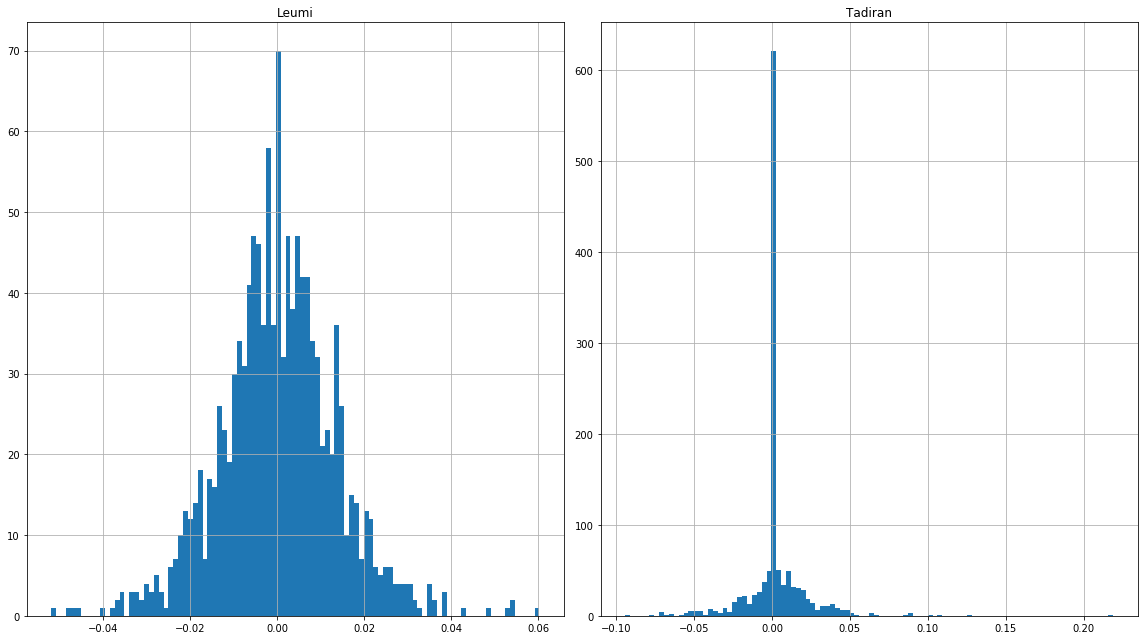

In [38]:
log_return.hist(bins = 100, figsize = (16,9))
plt.tight_layout()

In [39]:
log_return.mean()

Tadiran    0.001992
Leumi      0.000288
dtype: float64

In [143]:
def yearly_covariance(lreturn):
    return log_return.cov()*252

In [167]:
np.random.seed(101)
def effective_frontier(df,log_return):

    number_of_iterations = 2000
    weights = np.zeros((number_of_iterations,len(df.columns)))
    return_array = np.zeros(number_of_iterations)
    volatility_array = np.zeros(number_of_iterations)
    sharp_array = np.zeros(number_of_iterations)

    for num in range(number_of_iterations):

        #weights has to sum up to 1
        weight = np.array(np.random.random(len(df.columns)))
        weight = weight/np.sum(weight) 
        weights[num,:] = weight

        return_array[num] = np.sum((log_return.mean()*weight)*252)

        volatility_array[num] = np.sqrt(np.dot(weight.T,np.dot(log_return.cov()*252,weight)))

        sharp_array[num] = return_array[num]/ volatility_array[num]
        
    minimum_var = volatility_array.argmin()
    minimize_std_return = return_array[minimum_var]
    minimize_std_std = volatility_array[minimum_var]
    
    best_sharp = sharp_array.argmax()
    best_sharp_return = return_array[best_sharp]
    best_sharp_std = volatility_array[best_sharp]
    
    plt.figure(figsize=(16,9))
    plt.scatter(volatility_array,return_array,c = sharpe_array, cmap = 'cividis')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(minimize_std_std,minimize_std_return,c='r')
    plt.text(minimize_std_std, minimize_std_return, 'Best portfolio allocation by minimizing std', ha = 'left');
    plt.scatter(best_sharp_std,best_sharp_return,c='r')
    plt.text(best_sharp_std, best_sharp_return, 'Best portfolio allocation by sharp ratio', ha = 'right');
    plt.title('The efficeincy frontier')
        
    return plt.show();

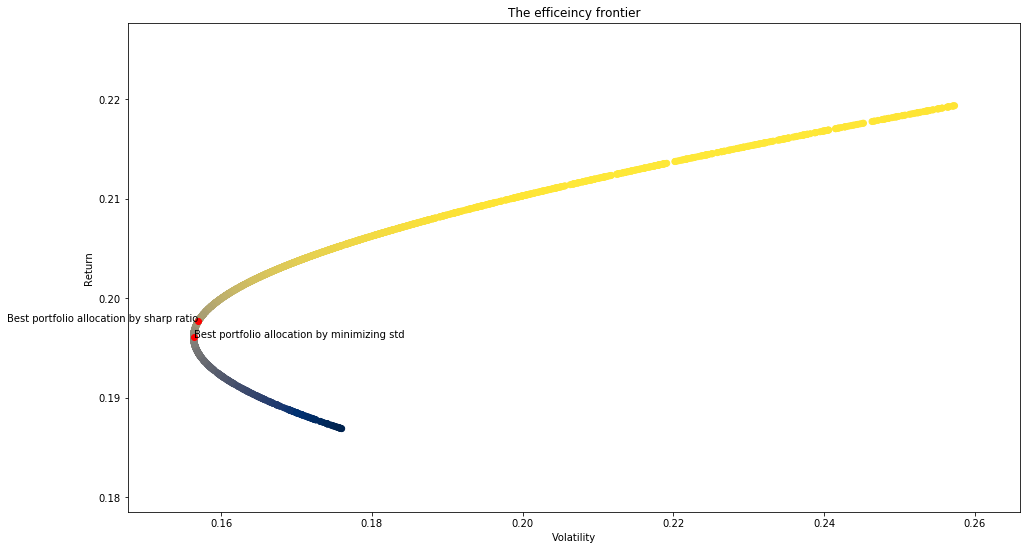

In [168]:
effective_frontier(df,log_return)

In [75]:
volatility_array.argmin()

894

In [76]:
weights[894,:]

array([0.31744159, 0.68255841])

In [77]:
return_array[894]

0.2088793496962633

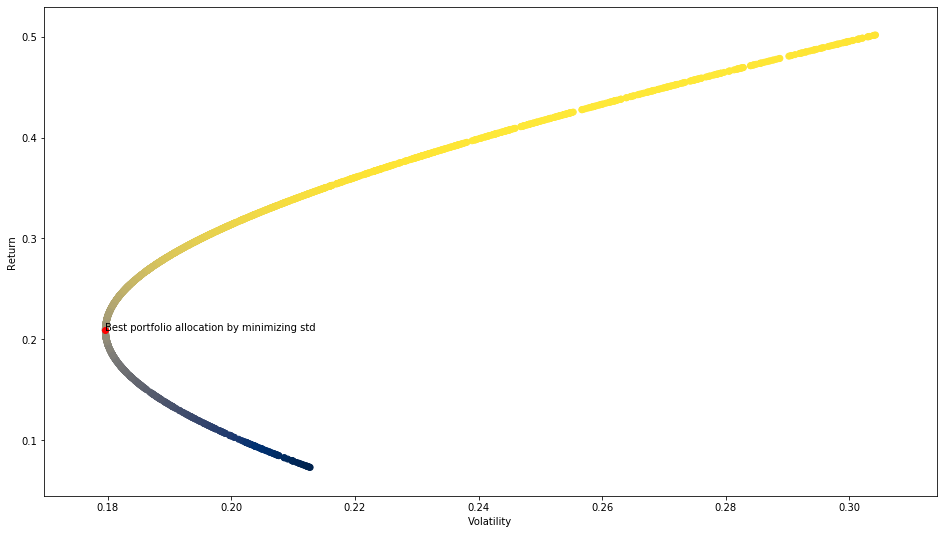

In [79]:
minimize_std_return = return_array[894]
minimize_std_std = volatility_array[894]
plt.figure(figsize=(16,9))
plt.scatter(volatility_array,return_array,c = sharpe_array, cmap = 'cividis')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(minimize_std_std,minimize_std_return,c='r')
plt.text(minimize_std_std, minimize_std_return, 'Best portfolio allocation by minimizing std', ha = 'left');

In [53]:
sharpe_array.argmax()

419

In [54]:
weights[419,:]

array([0.82881998, 0.17118002])

In [61]:
return_array[419]

0.42854228071607753

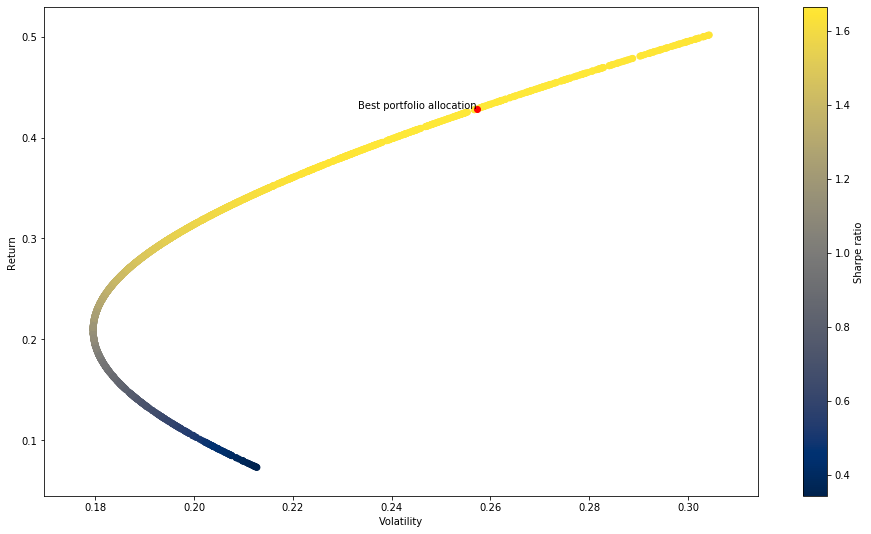

In [74]:
best_sharp_return = return_array[419]
best_sharp_std = volatility_array[419]
plt.figure(figsize=(16,9))
plt.scatter(volatility_array,return_array,c = sharpe_array, cmap = 'cividis')
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(best_sharp_std,best_sharp_return,c='r')
plt.text(best_sharp_std, best_sharp_return, 'Best portfolio allocation by sharp ratio', ha = 'right');

In [3]:
aapl = quandl.get('WIKI/AAPL.11',start_date = start, end_date = end)
cisco = quandl.get('WIKI/CSCO.11',start_date = start, end_date = end)
ibm = quandl.get('WIKI/IBM.11',start_date = start, end_date = end)
amazon = quandl.get('WIKI/AMZN.11',start_date = start, end_date = end)

In [5]:
for stock in (aapl,cisco,ibm,amazon):
    stock['Normalized Return'] = stock['Adj. Close']/stock.iloc[0]['Adj. Close']

In [6]:
aapl

,Adj. Close,Normalized Return
Date,,
2012-01-03,52.848787,1.000000
2012-01-04,53.132802,1.005374
2012-01-05,53.722681,1.016536
2012-01-06,54.284287,1.027162
2012-01-09,54.198183,1.025533
...,...,...
2016-12-23,115.080808,2.177549
2016-12-27,115.811668,2.191378
2016-12-28,115.317843,2.182034


ValueError: only 2 non-keyword arguments accepted